# Denoising Diffusion Probabilistic Models (DDPM) on MNIST

In [164]:
# Python imports
import random
import math
import abc
import os

# PyTorch imports
import torch
import torchvision

# Third-party imports
import matplotlib.pyplot as plt
from tabulate import tabulate
import clip
import PIL

# Own imports
import utils

## 0. Constants

In [2]:
# Hyper-parameters.
LEARNING_RATE = 5e-4
EPOCHS = 10
BATCH_SIZE = 32
DROPOUT = 0.1

# Diffusion model parameters.
TIME_STEPS = 500

# UNet model parameters.
MODEL_CHANNELS = 96
GROUP_NORM_GROUPS = 32

# Dataset parameters.
WIDTH = 64
HEIGHT = 64
CHANNELS = 3
HEIGHT_ORIGINAL = 218
WIDTH_ORIGINAL = 178

# Others
SAVED_FILENAME = 'CelebA'

### 0.1. Device

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

# Print the device to run the model.
print(f"Use device [{DEVICE}].")

Use device [cuda].


## 1. Dataset

In [4]:
# 1. Each item in dataset is a tuple of (torch.Tensor, torch.Tensor).
#    The first tensor is of shape (CHANNELS, HEIGHT, WIDTH) and dtype torch.float32, which is the image.
#    The second tensor is of shape (40,) and dtype torch.int64, which is the labels.
# 2. I use a custom utils.CelebA to load and cache the dataset, so that reading from hard drive during training is avoided.
dataset = utils.CelebA(
    './data',
    split='all',
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((HEIGHT, WIDTH), antialias=True),
    ]),
    cacheOnInit=False,
)

# samples = next(iter(dataloader))
# samples is a Python list of len 2.
# samples[0] is a tensor of shape (BATCH_SIZE, CHANNELS, WIDTH, HEIGHT) and dtype torch.float32.
# samples[1] is a tensor of shape (BATCH_SIZE, 40) and type torch.int64.
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified


Inspect statistics of the dataset.

In [5]:
# Get the size of the dataset.
dataset_size = len(dataset)

# Construct data structures used by tabulate.
headers = ['Property', 'Value']
rows = [
    ['Size', dataset_size],
]

# Print the table.
print(tabulate(rows, headers=headers, tablefmt='github'))

| Property   |   Value |
|------------|---------|
| Size       |  202599 |


Inspect samples from the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


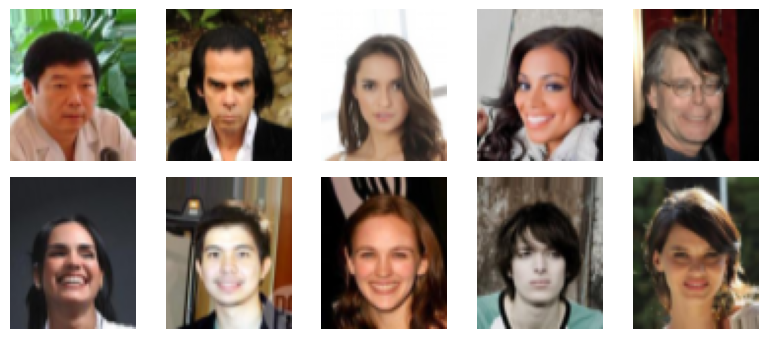

In [6]:
# Define a resize transformation to restore the aspect ratio.
ratio = HEIGHT_ORIGINAL / WIDTH_ORIGINAL
transform = torchvision.transforms.Resize((int(HEIGHT * ratio), WIDTH), antialias=True)

# Sample 10 unique indices from the index range of the dataset.
indices = random.sample(range(dataset_size), k=10)

# Plot figure.
rows, cols = 2, 5
fig, axs = plt.subplots(rows, cols, figsize=(8, 3.5))
for i in range(len(indices)):
    # Restore the aspect ratio of the image.
    image = transform(dataset[indices[i]][0])
    image = transform(image).permute(1, 2, 0)

    # Plot image.
    row = i // cols
    col = i % cols
    axs[row][col].imshow(image, cmap=plt.cm.gray)
    axs[row][col].axis('off')
plt.tight_layout()
plt.show()

## 2. Diffusion

In [7]:
class Diffusion:
    """Difusion class performs forward and backward diffusion."""

    def __init__(self, time_steps=1000):
        """
        Args:
            timesteps (int): maximum diffusion timesteps.
        """

        # Instance attributes.
        self.time_steps = time_steps

        # Perform pre-calculations.
        self._performPreCalculations()

    def q_sample(self, x_0, t, noise=None):
        """Perform forward diffusion.
        
        Args:
            x_0 (shape (batch_size, channels, height, width) & dtype torch.float32): original images.
            t (shape (batch_size,) & dtype torch.int64): time representation.

        Returns: noisy images of shape (batch_size, channels, height, width) and dtype torch.float32.
        """

        # Noise added to the images.
        # A tensor of shape (batch_size, channels, height, width) and dtype torch.float32.
        if noise == None:
            noise = torch.randn_like(x_0)

        # A tensor of shape (batch_size, 1, 1, 1) and dtype torch.float32.
        sqrt_alphas_cumprod = self._gatherFromTensor(self.sqrt_alphas_cumprod, t)
        # A tensor of shape (batch_size, 1, 1, 1) and dtype torch.float32.
        sqrt_one_minus_alphas_cumprod = self._gatherFromTensor(self.sqrt_one_minus_alphas_cumprod, t)

        # A tensor of shape (batch_size, channels, height, width) and dtype torch.float32.
        return sqrt_alphas_cumprod * x_0 + sqrt_one_minus_alphas_cumprod * noise
    
    def p_sample(self, x_t, t, model):
        """Sample x_{t-1} from x_t.
        
        Args:
            x_t (shape (batch_size, channels, height, width) & dtype torch.float32): noisy images.
            t (shape (batch_size,) & torch.int64): time representation.
        """

        # Predict the noise.
        model.eval()
        # A tensor of shape (batch_size, channels, height, width) and dtype torch.float32.
        with torch.no_grad():
            noise_predicted = model(x_t, t)

        # Reconstruct x_0.
        # A tensor of shape (batch_size, channels, height, width) and dtype torch.float32.
        x_0_reconstructed = self._x_0_from_noise(x_t, t, noise_predicted)
        x_0_reconstructed = x_0_reconstructed.clamp(min=-1, max=1)

        # Calculate posterior mean and variance.
        mean, variance, log_variance = self._posterior_mean_variance(x_0_reconstructed, x_t, t)

        # Sample a random noise.
        noise = torch.randn_like(x_t)

        # Generate a mask.
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))

        # Sample x_{t-1}.
        images_predicted = mean + nonzero_mask * (log_variance * 0.5).exp() * noise

        return images_predicted
    
    def sample(self, batch_size, channels, height, width, model):
        """Generate some image samples.
        
        Args:
            batch_size (int): number of image samples to generate.
            channels (int): number of channels.
            height (int): image height.
            width (int): image width.
            model (torch.nn.Module)
        """

        # Sample noise.
        noise = torch.randn((batch_size, channels, height, width), device=DEVICE)

        return self._p_sample_loop(noise, model)

    def _beta_schedule(self):
        """Generate betas for adding noise to images in a linear way.

        The article [1] uses 1000 time steps, and uses 0.0001 as the starting beta and 0.02 as the ending beta.
        If we use a different time steps, we need to scale it to make sure the noised added is enough.

        Return: A tensor of shape (self.time_steps,) and dtype torch.float32.
        """

        # Calculate the scale of the starting and ending betas.
        scale = 1000 / self.time_steps

        # Scale the starting and ending betas.
        beta_start_scaled = 0.0001 * scale
        beta_end_scaled = 0.02 * scale

        # Return a tensor of shape (self.time_steps,) and dtype torch.float32.
        return torch.linspace(start=beta_start_scaled, end=beta_end_scaled, steps=self.time_steps, device=DEVICE)

    def _performPreCalculations(self):
        """Perform pre-calculations."""

        # A tensor of shape (self.time_steps,) and dtype torch.float32.
        betas = self._beta_schedule()

        # A tensor of shape (self.time_steps,) and dtype torch.float32.
        alphas = 1 - betas

        # A tensor of shape (self.time_steps,) and dtype torch.float32.
        self.alphas_cumprod = alphas.cumprod(dim=0)

        # A tensor of shape (self.timestamps_max,) and dtype torch.float32.
        self.alphas_cumprod_prev = torch.nn.functional.pad(self.alphas_cumprod[:-1], pad=(1, 0), value=1)

        # A tensor of shape (self.time_steps,) and dtype torch.float32.
        self.sqrt_alphas_cumprod = self.alphas_cumprod.sqrt()

        # A tensor of shape (self.time_steps,) and dtype torch.float32.
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod).sqrt()

        # A tensor of shape (self.timestamps_max,) and dtype torch.float32.
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1 / self.alphas_cumprod)

        # A tensor of shape (self.timestamps_max,) and dtype torch.float32.
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1 / self.alphas_cumprod - 1)

        # A tensor of shape (self.timestamps_max,) and dtype torch.float32.
        self.posterior_mean_coef1 = betas * torch.sqrt(self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)

        # A tensor of shape (self.timestamps_max,) and dtype torch.float32.
        self.posterior_mean_coef2 = (1 - self.alphas_cumprod_prev) * torch.sqrt(alphas) / (1 - self.alphas_cumprod)

        # A tensor of shape (self.timestamps_max,) and dtype torch.float32.
        self.posterior_variance = betas * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)

        # A tensor of shape (self.timestamps_max,) and dtype torch.float32.
        self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min=1e-20))

    def _gatherFromTensor(self, tensor, t):
        """Gather from tensor by the index t and make the shape as (batch_size, 1, 1, 1).

        Args:
            tensor (shape (self.time_steps,) & dtype torch.float32): tensor to gather from.
            t (shape (batch_size,) & dtype torch.int64): time representation.

        Return: A tensor of shape (batch_size, 1, 1, 1).
        """

        # Calculate the batch size.
        batch_size = t.size()[0]

        # A tensor of shape (batch_size,) and torch.float32.
        tensor = tensor.gather(dim=0, index=t)

        # A tensor of shape (batch_size, 1, 1, 1) and torch.float32.
        return tensor.reshape(batch_size, 1, 1, 1)
    
    def _p_sample_loop(self, noise, model):
        """Perform backward diffusion iteratively.
        
        Args:
            noise (shape (batch_size, channels, height, width) & dtype torch.float32)
            model (torch.nn.Module)

        Return: images of shape (batch_size, channels, height, width) and dtype torch.float32.
        """

        # Calculate the batch size.
        batch_size = noise.size()[0]

        images = noise
        for i in reversed(range(self.time_steps)):
            # A tensor of shape (batch_size,) and dtype torch.int64.
            t = torch.full((batch_size,), i, dtype=torch.int64, device=DEVICE)
            # A tensor of shape (batch_size, channels, height, width) and dtype torch.float32.
            images = self.p_sample(images, t, model)

        # A tensor of shape (batch_size, channels, height, width) and dtype torch.float32.
        return images
    
    def _x_0_from_noise(self, x_t, t, noise):
        """Predict x_0 from x_t and noise.
        
        Args:
            x_t (shape (batch_size, channels, height, width) & dtype torch.float32)
            t (shape (batch_size,) & dtype torch.int64)
            noise (shape (batch_size, channels, height, width) & dtype torch.float32)

        Return x_0 of shape (batch_size, channels, height, width) and dtype torch.float32.
        """

        # A tensor of shape (BATCH_SIZE, 1, 1, 1) and dtype torch.float32.
        sqrt_recip_alphas_cumprod_t = self._gatherFromTensor(self.sqrt_recip_alphas_cumprod, t)
        # A tensor of shape (BATCH_SIZE, 1, 1, 1) and dtype torch.float32.
        sqrt_recipm1_alphas_cumprod_t = self._gatherFromTensor(self.sqrt_recipm1_alphas_cumprod, t)

        # A tensor of shape (BATCH_SIZE, 1, 1, 1) and dtype torch.float32.
        return sqrt_recip_alphas_cumprod_t * x_t - sqrt_recipm1_alphas_cumprod_t * noise
    
    def _posterior_mean_variance(self, x_0, x_t, t):
        """Calculate posterior mean and variance."""

        posterior_mean_coef1 = self._gatherFromTensor(self.posterior_mean_coef1, t)
        posterior_mean_coef2 = self._gatherFromTensor(self.posterior_mean_coef2, t)

        posterior_mean = posterior_mean_coef1 * x_0 + posterior_mean_coef2 * x_t
        posterior_variance = self._gatherFromTensor(self.posterior_variance, t)
        posterior_log_variance_clipped = self._gatherFromTensor(self.posterior_log_variance_clipped, t)

        return posterior_mean, posterior_variance, posterior_log_variance_clipped

diffusion = Diffusion(TIME_STEPS)

### 2.1. Forward Diffusion

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


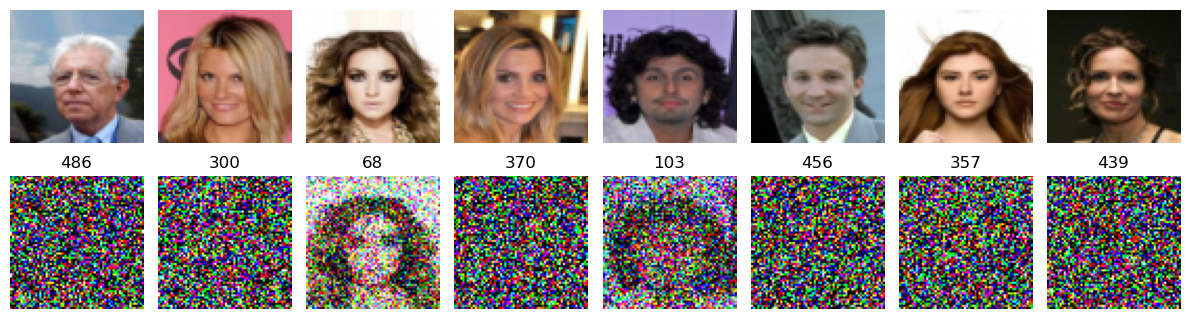

In [8]:
num_samples = 8

# Sample images from the dataset.
# A tensor of shape (num_samples, CHANNELS, HEIGHT, WIDTH) and dtype torch.float32.
images = next(iter(dataloader))[0][:num_samples].to(DEVICE)

# Sample time steps that are in [0, TIME_STEPS).
# A tensor of shape (num_samples,) and dtype torch.int64.
t = torch.randint(0, TIME_STEPS, (8,), device=DEVICE)

# Add noise to the images.
# A tensor of shape (num_samples, CHANNELS, HEIGHT, WIDTH) and dtype torch.float32.
noisy_images = diffusion.q_sample(images, t).clamp(min=0, max=1)

# Show the noisy images.
rows, cols = 2, num_samples
fig, axs = plt.subplots(rows, cols, figsize=(12, 3.5))
for col in range(cols):
    axs[0][col].imshow(images[col].permute(1, 2, 0).cpu(), cmap=plt.cm.gray)
    axs[0][col].axis('off')
for col in range(cols):
    axs[1][col].imshow(noisy_images[col].permute(1, 2, 0).cpu(), cmap=plt.cm.gray)
    axs[1][col].axis('off')
    axs[1][col].set_title(t[col].item())
plt.tight_layout()
plt.show()

## 3. Model

### 3.1. Time embedding.

In [9]:
def time_embed(t, dims, period_max=10000.):
    """Calculate embedding for time steps.

    Args:
        t (shape (batch_size,) & dtype torch.int64): time representation.
        dims (int): dimensions of the embedding.
        period_max(float): max period of sinusoidal and cosinoidal functions.

    Return: time embedding of shape (batch_size, dim) and dtype torch.float32.
    """

    # batch_size is a Python int.
    batch_size = t.size()[0]

    # Calculate half of the embedding dimension.
    # half is a Python int.
    half = dims // 2

    # Calculate the parameter w that controls frequencies.
    # A tensor of shape (half,) and dtype torch.float32.
    w = torch.exp(
        -math.log(period_max) *
        torch.arange(start=0, end=half, dtype=torch.float32, device=DEVICE) / half
    )
    
    # args is the arguments of sinusoidal and cosinoidal functions.
    # args is a tensor of shape (batch_size, half) and dtype torch.float32.
    # t[:, None] is a tensor of shape (batch_size, 1) and dtype torch.int64.
    # w[None, :] is a tensor of shape (1, half) and dtype torch.float32.
    args = t[:, None].float() * w[None, :]
    
    # A tensor of shape (batch_size, half*2) and dtype torch.float32.
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

    # A tensor of shape (batch_size, dim) and dtype torch.float32.
    if dims % 2 != 0:
        embedding = torch.cat([embedding, torch.zeros(batch_size, 1)], dim=-1)

    # A tensor of shape (batch_size, dim) and dtype torch.float32.
    return embedding

### 3.2. Blocks

Define a module that accepts time embedding.

In [10]:
class EmbeddingBlock(torch.nn.Module, abc.ABC):
    """Any module whose forward method takes time embedding as a second argument."""

    @abc.abstractmethod
    def forward(self, x, embedding):
        """Take x and embbeding as the inputs."""

Define a sequential module that contains EmbeddingBlock.

In [11]:
class EmbeddingSequential(torch.nn.Sequential, EmbeddingBlock):
    """A sequential module that contains EmbeddingBlock."""

    def forward(self, x, embedding):
        """Take x and embbeding as the inputs."""

        for layer in self:
            if isinstance(layer, EmbeddingBlock):
                x = layer(x, embedding)
            else:
                x = layer(x)
        
        return x

Define the residual block.

In [12]:
class ResidualBlock(EmbeddingBlock):
    """Residual block."""

    def __init__(self, in_channels, out_channels, time_embedding_channels, groups, dropout):
        """
        Args:
            in_channels (int): channels of the input.
            out_channels (int): channels of the output.
            time_embedding_channels (int): channels of the time embedding.
            groups (int): number of groups for group normalization. in_channels and out_channels must be divisible by groups.
            dropout (float): dropout rate.
        """

        super().__init__()

        # Input is a tensor of shape (batch_size, in_channels, height, width) and dtype torch.float32.
        # Output is a tensor of shape (batch_size, out_channels, height, width) and dtype torch.float32.
        self.conv1 = torch.nn.Sequential(
            torch.nn.GroupNorm(groups, in_channels),
            torch.nn.SiLU(),
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
        )

        # Input is a tensor of shape (batch_size, time_embedding_channels) and dtype torch.float32.
        # Output is a tensor of shape (batch_size, out_channels) and dtype torch.float32.
        self.embedding = torch.nn.Sequential(
            torch.nn.SiLU(),
            torch.nn.Linear(time_embedding_channels, out_channels),
        )

        # Input is a tensor of shape (batch_size, out_channels, height, width) and dtype torch.float32.
        # Output is a tensor of shape (batch_size, out_channels) and dtype torch.float32.
        self.conv2 = torch.nn.Sequential(
            torch.nn.GroupNorm(groups, out_channels),
            torch.nn.SiLU(),
            torch.nn.Dropout(p=dropout),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
        )

        # Shortcut of the residual block.
        if in_channels != out_channels:
            self.shortcut = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = torch.nn.Identity()

    def forward(self, x, embedding):
        """
        Args:
            x (shape (batch_size, in_channels, height, width) & dtype torch.float32)
            embedding (shape (batch_size, time_embedding_channels) & dtype torch.float32)

        Return: a tensor of shape (batch_size, out_channels, height, width) and dtype torch.float32.
        """

        # A tensor of shape (batch_size, out_channels, height, width) and dtype ttorch.float32.
        out = self.conv1(x)
        # A tensor of shape (batch_size, out_channels, height, width) and dtype ttorch.float32.
        out += self.embedding(embedding)[:, :, None, None]
        # A tensor of shape (batch_size, out_channels, height, width) and dtype ttorch.float32.
        out = self.conv2(out)

        # A tensor of shape (batch_size, out_channels, height, width) and dtype ttorch.float32.
        return out + self.shortcut(x)

Define a down sampler class.

In [13]:
class DownSampler(torch.nn.Module):
    """Down sampler that halves the height and width."""

    def __init__(self, channels):
        """
        Args:
            channels (int): number of channels.
        """

        super().__init__()

        # Input is a tensor of shape (batch_size, channels, height, width) and dtype torch.float32.
        # Output is a tensor of shape (batch_size, channels, ceil(height / 2), ceil(width / 2) and dtype torch.float32.
        self.conv = torch.nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        """
        Args:
            x (shape (batch_size, channels, height, width) & dtype torch.float32)

        Return: a tensor of shape (batch_size, channels, ceil(height / 2), ceil(width / 2) and dtype torch.float32.
        """

        # A tensor of shape (batch_size, channels, ceil(height / 2), ceil(width / 2) and dtype torch.float32.
        return self.conv(x)

Define an up sampler class.

In [14]:
class UpSampler(torch.nn.Module):
    """Up sampler that doubles the height and width."""

    def __init__(self, channels):
        """
        Args:
            channels (int): number of channels.
        """

        super().__init__()

        # Input is a tensor of shape (batch_size, channels, height, width) and dtype torch.float32.
        # Output is a tensor of shape (batch_size, channels, height, width and dtype torch.float32.
        self.conv = torch.nn.Conv2d(channels, channels, kernel_size=3, padding='same')

    def forward(self, x):
        """
        Args:
            x (shape (batch_size, channels, height, width) & dtype torch.float32)

        Return: a tensor of shape (batch_size, channels, height * 2, width * 2) and dtype torch.float32.
        """

        # A tensor of shape (batch_size, channels, height * 2, width * 2) and dtype torch.float32.
        x = torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')
        # A tensor of shape (batch_size, channels, height * 2, width * 2) and dtype torch.float32.
        x = self.conv(x)

        # A tensor of shape (batch_size, channels, height * 2, width * 2) and dtype torch.float32.
        return x

### 3.3. UNet

In [15]:
class UNet(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, model_channels, groups, channel_factors=(1, 2, 2), res_blocks=2, dropout=0.1):
        """
        Args:
            in_channels (int): number of channels of the input.
            out_channels (int): number of channels of the output.
            model_channels (int): base number of channels of the model.
            groups (int): number of groups for group normalization. model_channels must be divisible by groups.
            channel_factors (tuple of int): defines number of levels and channel factors.
            res_blocks (int): number of residual blocks of each level.
            dropout (float): dropout rate.
        """

        super().__init__()

        # Instance attributes.
        self.model_channels = model_channels

        # Time embedding.
        time_embedding_channels = model_channels * 4
        self.embed = torch.nn.Sequential(
            torch.nn.Linear(model_channels, time_embedding_channels),
            torch.nn.SiLU(),
            torch.nn.Linear(time_embedding_channels, time_embedding_channels)
        )

        # Necessary variables for UNet.
        channels = model_channels
        down_block_channels = [channels]

        # Down sampling state.
        self.down_blocks = torch.nn.ModuleList([
            EmbeddingSequential(torch.nn.Conv2d(in_channels, model_channels, kernel_size=3, padding='same'))
        ])
        for level, channel_factor in enumerate(channel_factors):
            for _ in range(res_blocks):
                layers = [
                    ResidualBlock(channels, model_channels * channel_factor, time_embedding_channels, groups, dropout),
                ]
                channels = model_channels * channel_factor
                self.down_blocks.append(EmbeddingSequential(*layers))
                down_block_channels.append(channels)
            if level != len(channel_factors)-1:
                self.down_blocks.append(EmbeddingSequential(DownSampler(channels)))
                down_block_channels.append(channels)

        # Middle stage.
        self.middle_blocks = EmbeddingSequential(
            ResidualBlock(channels, channels, time_embedding_channels, groups, dropout),
            ResidualBlock(channels, channels, time_embedding_channels, groups, dropout),
        )

        # Up sampling stage.
        self.up_blocks = torch.nn.ModuleList([])
        for level, channel_factor in list(enumerate(channel_factors))[::-1]:
            for i in range(res_blocks+1):
                layers = [
                    ResidualBlock(channels + down_block_channels.pop(), model_channels * channel_factor, time_embedding_channels, groups, dropout),
                ]
                channels = model_channels * channel_factor
                if level > 0 and i == res_blocks:
                    layers.append(UpSampler(channels))
                self.up_blocks.append(EmbeddingSequential(*layers))

        # Output block.
        self.output_block = torch.nn.Sequential(
            torch.nn.GroupNorm(groups, channels),
            torch.nn.SiLU(),
            torch.nn.Conv2d(model_channels, out_channels, kernel_size=3, padding='same')
        )

    def forward(self, x_t, t):
        """
        Args:
            x_t (shape (batch_size, channels, height, width) & dtype torch.float32): noisy images.
            t (shape (batch_size,) & dtype torch.int64): time representation.
        """

        # Output of each layer.
        out = x_t

        # Skip connections.
        outs = []

        # embedding is a tensor of shape (batch_size, self.model_channels * 4) and dtype torch.float32.
        embedding = self.embed(time_embed(t, self.model_channels))

        # Down sampling stage.
        for module in self.down_blocks:
            out = module(out, embedding)
            outs.append(out)

        # Middle stage.
        out = self.middle_blocks(out, embedding)

        # Up sampling stage.
        for module in self.up_blocks:
            out = module(torch.cat([out, outs.pop()], dim=1), embedding)

        # Output block.
        out = self.output_block(out)

        return out
    
model = UNet(CHANNELS, CHANNELS, MODEL_CHANNELS, GROUP_NORM_GROUPS).to(DEVICE)

Inspect statistics of the model.

In [16]:
# Calculate the total number of parameters.
num_parameters_total = 0
for params in model.parameters():
    num_parameters = 1
    size = params.size()
    for dim_size in size:
        num_parameters *= dim_size
    num_parameters_total += num_parameters

# Construct data structures used by tabulate.
headers = ['Property', 'Value']
rows = [
    ['# of Params', num_parameters_total],
]

# Print the table.
print(tabulate(rows, headers=headers, tablefmt='github'))

| Property    |    Value |
|-------------|----------|
| # of Params | 13651971 |


## 4. Training

Define a function to load from saved data.

In [17]:
def load(model, file_path):
    """Load the saved data.
    
    Return losses: losses of the training process.
    """
    
    # Retrieve saved data.
    data = torch.load(file_path)

    # Resume model from saved data.
    state_dict = data['state_dict']
    model.load_state_dict(state_dict)

    # A list of floats.
    return data['losses']

Define a function to save data.

In [18]:
def save(model, losses, file_path):
    """Save the data.
    
    Args:
        model (torch.nn.Module)
        losses (list of float): losses of the training process.
        file_path (string)
    """
    
    # Create the folder if it does not exist.
    folder_path = os.path.dirname(file_path)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Construct the struct of data to save.
    data = {
        'state_dict': model.state_dict(),
        'losses': losses,
    }

    # Save data to the file.
    torch.save(data, file_path)

Define a function to calculate statistics on a dataset.

In [19]:
def calculateStatistics(model, dataloader, loss_fn, diffussion):
    """Calculate statistics of a model on a dataset.

    The statistics include:
    1. mean loss.

    Args:
        model (torch.nn.Module)
        dataloader (torch.utils.data.DataLoader)
        loss_fn: loss function.
        diffusion (Diffusion)

    Return: the mean loss (float).
    """

    # Put model into evaluation mode.
    model.eval()
    
    with torch.no_grad():
        loss = 0

        for images, _ in dataloader:
            images = images.to(DEVICE)

            # Calculate batch size.
            # Note that the last batch may not be equal to the pre-defined batch size.
            batch_size = images.size()[0]

            # Generate noise and predicted noise
            noise = torch.randn_like(images, device=DEVICE)
            t = torch.randint(0, TIME_STEPS, (batch_size,), device=DEVICE)
            noisy_images = diffusion.q_sample(images, t, noise)
            noise_predicted = model(noisy_images, t)

            # Calculate the loss.
            loss += loss_fn(noise, noise_predicted)

        # Calculate the mean loss.
        batches = len(dataloader)
        loss /= batches

    # Convert a tensor of torch.float32 to a Python float.
    return loss.item()

Define a function to train one epoch.

In [20]:
def trainOneEpoch(model, dataloader, loss_fn, optimizer, diffusion):
    """Train the model for one epoch.
    
    Return: mean loss of the epoch (float).
    """

    # Put model into training mode.
    model.train(mode=True)

    # Mean loss of the epoch.
    loss_epoch = 0

    for batch, [images, _] in enumerate(dataloader):
        # Move data to the proper device.
        images = images.to(DEVICE)

        # Calculate batch size.
        # Note that the last batch may not be equal to the pre-defined batch size.
        batch_size = images.size()[0]

        # Generate noise and predicted noise
        noise = torch.randn_like(images, device=DEVICE)
        t = torch.randint(0, diffusion.time_steps, (batch_size,), device=DEVICE)
        noisy_images = diffusion.q_sample(images, t, noise)
        noise_predicted = model(noisy_images, t)

        # Reset gradients.
        optimizer.zero_grad()

        # Calculate loss and gradients.
        loss = loss_fn(noise, noise_predicted)
        loss_epoch += loss

        # Do back propagation.
        loss.backward()

        # Update gradients.
        optimizer.step()

    # Calculate mean loss of the epoch.
    batches = len(dataloader)
    # A tensor of torch.float32.
    loss_epoch /= batches

    # Convert a tensor of torch.float32 to a Python float.
    return loss_epoch.item()

Define a function to train multiple epochs

In [21]:
def train(
        model,
        dataloader,
        learning_rate,
        epochs,
        diffusion,
        use_pretrained=True,
    ):
    """Train the model for multiple epochs.
    
    Return: mean losses of the epochs (list of float).
    """

    # Get file path of pre-trained data.
    saved_file_path = f'saved/{SAVED_FILENAME}.pt'

    # Losses of the training process.
    # A list of floats.
    losses = []

    if use_pretrained:
        if os.path.exists(saved_file_path):
            losses = load(model, saved_file_path)
            return losses

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), learning_rate)

    # Calculate the statistics before the first epoch.
    loss = calculateStatistics(model, dataloader, loss_fn, diffusion) # A float.
    losses.append(loss)

    for epoch in range(epochs):
        loss_epoch = trainOneEpoch(model, dataloader, loss_fn, optimizer, diffusion)
        losses.append(loss_epoch)
        print(f'Epoch #{epoch}: loss ({loss_epoch})')

    save(model, losses, saved_file_path)

    return losses

Run training.

In [22]:
# A list of floats.
losses = train(model, dataloader, LEARNING_RATE, EPOCHS, diffusion)

Plot the training process.

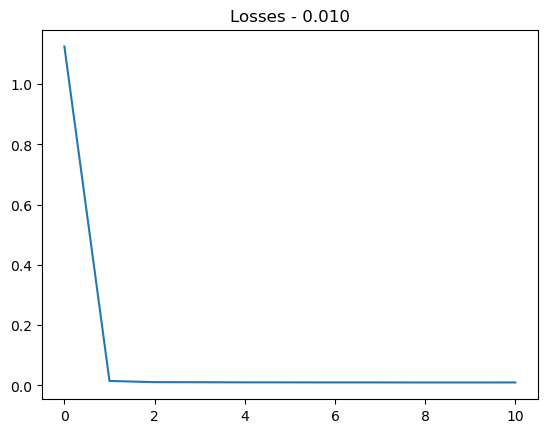

In [23]:
plt.plot(losses)
plt.title(f'Losses - {losses[-1]:.3f}')
plt.show()

## 5. Generation

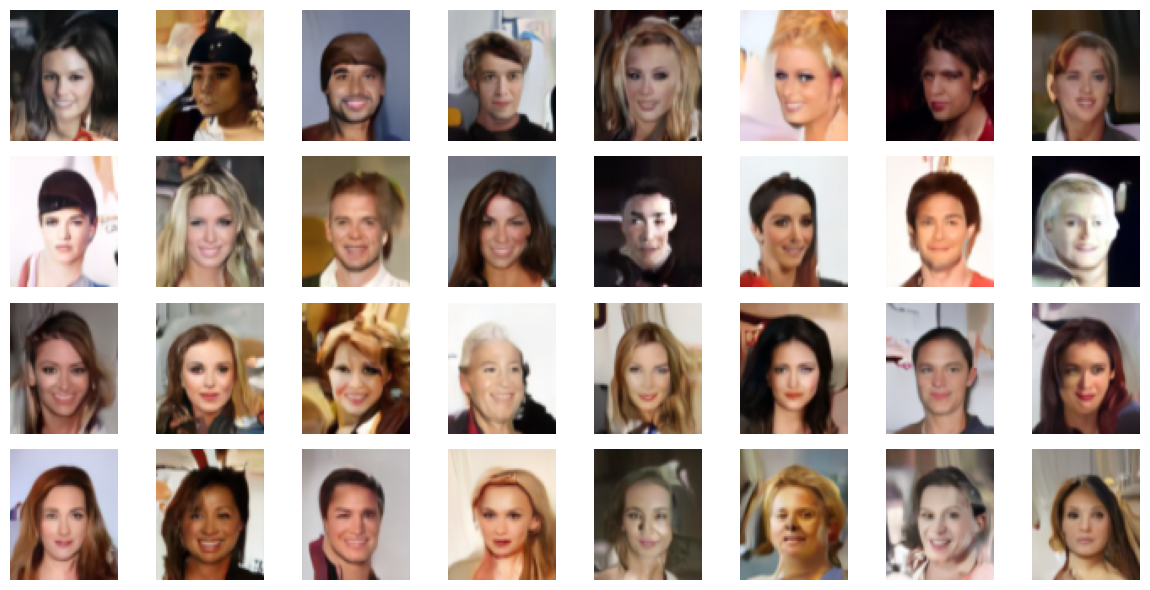

In [24]:
# Define a resize transformation to restore the aspect ratio.
ratio = HEIGHT_ORIGINAL / WIDTH_ORIGINAL
transform = torchvision.transforms.Resize((int(HEIGHT * ratio), WIDTH), antialias=True)

# Sample images and restore the aspect ratio.
image_predicted = diffusion.sample(BATCH_SIZE, CHANNELS, HEIGHT, WIDTH, model).clamp(min=0, max=1)
image_predicted = transform(image_predicted)

cols = 8
rows = BATCH_SIZE // cols if BATCH_SIZE % cols == 0 else BATCH_SIZE // cols + 1
fig, axs = plt.subplots(rows, cols, figsize=(12, 6))
for i in range(BATCH_SIZE):
    row = i // cols
    col = i % cols
    axs[row][col].imshow(image_predicted[i].detach().cpu().permute(1, 2, 0), cmap=plt.cm.gray)
    axs[row][col].axis('off')
plt.tight_layout()
plt.show()

In [126]:
tensor = torch.randn((3, 64, 64)) - 0.1
transform = torchvision.transforms.ToPILImage()
image = transform(tensor)
image.save('./saved/CelebA/0.jpg')

### 5.1. Evaluation

Constants for evaluation.

In [163]:
HEIGHT_EVALUATION = 224
WIDTH_EVALUATION = 224
BATCH_SIZE_EVALUATION = 64
BATCHES_EVALUATION = 100

Generate a collection of images for evaluation.

In [171]:
# Load saved images.
dirname = f'./saved/{SAVED_FILENAME}'
if os.path.exists(dirname):
    imagenames = [filename for filename in os.listdir(dirname) if os.path.isfile(os.path.join(dirname, filename))]
else:
    imagenames = []

# Number of images that are already generated.
num_done = len(imagenames)

# Generate images if the existent images are not enough.
for i in range(num_done, BATCH_SIZE_EVALUATION * BATCHES_EVALUATION, BATCH_SIZE_EVALUATION):

    # Calculate the actual batch size.
    batch_size = BATCH_SIZE_EVALUATION
    if i + batch_size > BATCH_SIZE_EVALUATION * BATCHES_EVALUATION:
        batch_size = BATCH_SIZE_EVALUATION * BATCHES_EVALUATION - i
    if batch_size == 0:
        break

    # Generate images.
    images_generated = diffusion.sample(batch_size, CHANNELS, HEIGHT, WIDTH, model).to(DEVICE)

    # Clamp the pixel values to [0, 1].
    images_generated = images_generated.clamp(min=0, max=1)

    # Define a transform to convert a tensor to PIL.Image.
    toPILImage = torchvision.transforms.ToPILImage()

    # Create the directory to save images if it does not exist.
    if not os.path.exists(dirname):
        os.makedirs(f'./saved/{SAVED_FILENAME}')

    # Save images to files.
    for j in range(images_generated.shape[0]):
        image = toPILImage(images_generated[j])
        image.save(f'./saved/{SAVED_FILENAME}/{i+j}.jpg')

# Read images.
toTensor = torchvision.transforms.ToTensor() # A transform that convert PIL.Image to torch.Tensor.
# List of tensor (shape (CHANNEL, HEIGHT, WIDTH), dtype torch.float32)
images_generated = []
for i in range(BATCH_SIZE_EVALUATION * BATCHES_EVALUATION):
    image_generated = PIL.Image.open(f'./saved/{SAVED_FILENAME}/{i}.jpg')
    images_generated.append(toTensor(image_generated))

# Concatenate tensors.
# shape (BATCH_SIZE_EVALUATION * BATCHES_EVALUATION, CHANNELS, HEIGHT, WIDTH), dtype torch.float32
images_generated = torch.stack(images_generated, dim=0).to(DEVICE)

Sample a collection of images for evaluation.

In [27]:
# Sample unique indices from the index range of the dataset.
indices = random.sample(range(dataset_size), k=BATCH_SIZE_EVALUATION*BATCHES_EVALUATION)

images_groundtruth = []
for index in indices:
    images_groundtruth.append(dataset[index][0])

# shape (BATCH_SIZE_EVALUATION*BATCHES_EVALUATION, CHANNELS, HEIGHT, WIDTH), dtype torch.float32.
images_groundtruth = torch.stack(images_groundtruth, dim=0).to(DEVICE)

Resize images.

In [28]:
resizer = torchvision.transforms.Resize((HEIGHT_EVALUATION, WIDTH_EVALUATION), antialias=True)

# shape (BATCH_SIZE_EVALUATION*BATCHES_EVALUATION, CHANNELS, HEIGHT_EVALUATION, WIDTH_EVALUATION), dtype torch.float32.
images_generated = resizer(images_generated)
# shape (BATCH_SIZE_EVALUATION*BATCHES_EVALUATION, CHANNELS, HEIGHT_EVALUATION, WIDTH_EVALUATION), dtype torch.float32.
images_groundtruth = resizer(images_groundtruth)

Load an OpenAI pre-trained CLIP model.

In [29]:
modelCLIP, _ = clip.load("ViT-B/32", device=DEVICE)

Define a function to calculate the features of images.

In [30]:
def calculateFeatures(model, images):
    """Calculate features of the images by the model.
    
    Args:
        model (torch.nn.Module)
        images (shape (batch_size, channels, HEIGHT_EVALUATION, WIDTH_EVALUATION))

    Return: a tensor (shape (batch_size, 512), dtype torch.float16).
    """

    model.eval()
    with torch.no_grad():
        features = model.encode_image(images)

    return features

Calculate features of the generated and groundtruth images.

In [31]:
# shape (BATCH_SIZE_EVALUATION*BATCHES_EVALUATION, 512), dtype torch.float16.
# features_generated = calculateFeatures(modelCLIP, images_generated)
# shape (BATCH_SIZE_EVALUATION*BATCHES_EVALUATION, 512), dtype torch.float16.
# features_groundtruth = calculateFeatures(modelCLIP, images_groundtruth)

Define a function to calculate the FID between generated and groundtruth images.

In [52]:
def FID(features_generated, features_groundtruth):
    """"""

    # Calculate mean features of the generated and groundtruth features.

    # shape (512,), dtype torch.float16
    mean_generated = features_generated.T.mean(dim=1)
    # shape (512,), dtype torch.float16
    mean_groundtruth = features_groundtruth.T.mean(dim=1)

    # Calculate covariance matrix of the generated and groundtruth features.

    # shape (512, 512), dtype torch.float16
    C_generated = features_generated.T.cov()
    # shape (512, 512), dtype torch.float16
    C_groundtruth = features_groundtruth.T.cov()

    score = torch.sum(torch.pow(mean_generated - mean_groundtruth, 2)) + torch.trace(C_generated + C_groundtruth - 2 * torch.sqrt(torch.abs(C_generated @ C_groundtruth)))

    return score

In [53]:
# fid_score = FID(features_generated, features_groundtruth)
# print(fid_score)

tensor(-98.5000, device='cuda:0', dtype=torch.float16)
